# Susceptibility to substitution

## 1 Setup

Flags and settings.

In [1]:
SAVE_FIGURES = False
PAPER_FEATURES = ['frequency', 'aoa', 'clustering', 'letters_count',
                  'synonyms_count', 'orthographic_density']
BIN_COUNT = 4

Imports and database setup.

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from statsmodels.stats.proportion import multinomial_proportions_confint

%cd -q ..
from brainscopypaste.conf import settings
%cd -q notebooks
from brainscopypaste.mine import Model, Time, Source, Past, Durl
from brainscopypaste.db import Substitution
from brainscopypaste.utils import init_db, session_scope, stopwords
engine = init_db()

Build our data.

In [3]:
def qposition(values, position):
    value = values[position]
    if np.isnan(value):
        return np.nan, np.nan
    finite_values = values[np.isfinite(values)]
    svalues = np.array(sorted(finite_values))
    length = len(svalues)
    ours = np.where(svalues == value)[0]
    return ours[0] / length, (ours[-1] + 1) / length

In [4]:
model = Model(time=Time.discrete, source=Source.majority, past=Past.all, durl=Durl.all, max_distance=2)
stop_poses = ['C', 'F', 'I', 'M', 'P', 'S', 'U']

data = []

# First get the exact substitution ids so we can get a working progress bar
# in the next step.
with session_scope() as session:
    substitutions = session.query(Substitution.id)\
        .filter(Substitution.model == model)
    print("Got {} substitutions for model {}"
          .format(substitutions.count(), model))
    substitution_ids = [id for (id,) in substitutions]

for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        # Prepare these arrays for use in stopword-checking.
        dslice = slice(substitution.start,
                       substitution.start
                       + len(substitution.destination.tokens))
        lemmas = substitution.source.lemmas[dslice]
        tokens = substitution.source.tokens[dslice]
        tags = substitution.source.tags[dslice]
        is_stopword = np.array([(lemma in stopwords)
                                or (token in stopwords)
                                for (lemma, token) in zip(lemmas, tokens)])
        
        for feature in Substitution.__features__:
            
            # Get feature values for the sentence and its words.
            sentence_values, _ = substitution.\
                source_destination_features(feature)
            sentence_values_rel, _ = substitution.\
                source_destination_features(feature,
                                            sentence_relative='median')
            source_type, _ = Substitution.__features__[feature]
            words = getattr(substitution.source, source_type)[dslice]
            
            # Find the bins we'll use.
            # If there are only NaNs or only one feature value
            # we can't get bins on this sentence, so we want at least
            # 2 different feature values.
            # We also skip feature values if the source word is not coded
            # for the feature, as it would skew the 'appeared' 
            # distributions compared to the distribution of substituted
            # words. (For instance, the sum of categories would not be 
            # equal to the sum of H0s in the very last graphs, 
            # on sentencequantile. It also lets us make meaningful H0
            # comparison in all the other feature-based graphs.)
            non_sw_values = sentence_values.copy()
            non_sw_values[is_stopword] = np.nan
            non_sw_value_set = \
                set(non_sw_values[np.isfinite(non_sw_values)])
            if (len(non_sw_value_set) <= 1 or
                    np.isnan(sentence_values[substitution.position])):
                allnans = [np.nan] * len(non_sw_values)
                bins = allnans
                non_sw_values = allnans
                sentence_values = allnans
                sentence_values_rel = allnans
            else:
                bins = pd.cut(non_sw_values, BIN_COUNT, labels=False)
            
            # For each non-stopword, store its various properties.
            for i, (word, tag, skip) in enumerate(zip(words, tags,
                                                      is_stopword)):
                if skip:
                    # Drop any stopwords.
                    continue

                # Get a readable POS tag
                rtag = tag[0]
                rtag = 'Stopword-like' if rtag in stop_poses else rtag
                
                # Get the word's quantile position.
                start_quantile, stop_quantile = qposition(non_sw_values, i)

                # Store the word's properties.
                data.append({
                    'cluster_id': substitution.source.cluster.sid,
                    'destination_id': substitution.destination.sid,
                    'occurrence': substitution.occurrence,
                    'source_id': substitution.source.sid,
                    'position': substitution.position,
                    'feature': feature,
                    'word': word,
                    'POS': tag,
                    'rPOS': rtag,
                    'target': i == substitution.position,
                    'value': sentence_values[i],
                    'value_rel': sentence_values_rel[i],
                    'bin': bins[i],
                    'start_quantile': start_quantile,
                    'stop_quantile': stop_quantile,
                    'word_position': i
                })

words = pd.DataFrame(data)
del data

Got 24971 substitutions for model Model(time=Time.discrete, source=Source.majority, past=Past.all, durl=Durl.all, max_distance=2)


  0% (    1 of 24971) |             | Elapsed Time: 0:00:04 ETA:  1 day, 4:44:10

  0% (   81 of 24971) |                    | Elapsed Time: 0:00:05 ETA:  0:05:08

  0% (  167 of 24971) |                    | Elapsed Time: 0:00:06 ETA:  0:04:56

  1% (  255 of 24971) |                    | Elapsed Time: 0:00:07 ETA:  0:04:50

  1% (  313 of 24971) |                    | Elapsed Time: 0:00:07 ETA:  0:04:46

  1% (  398 of 24971) |                    | Elapsed Time: 0:00:08 ETA:  0:04:46

  1% (  486 of 24971) |                    | Elapsed Time: 0:00:09 ETA:  0:04:43

  2% (  570 of 24971) |                    | Elapsed Time: 0:00:10 ETA:  0:04:43

  2% (  625 of 24971) |                    | Elapsed Time: 0:00:11 ETA:  0:04:44

  2% (  699 of 24971) |                    | Elapsed Time: 0:00:12 ETA:  0:04:48

  3% (  774 of 24971) |                    | Elapsed Time: 0:00:13 ETA:  0:04:50

  3% (  858 of 24971) |                    | Elapsed Time: 0:00:14 ETA:  0:04:49

  3% (  937 of 24971) |                    | Elapsed Time: 0:00:15 ETA:  0:04:48

  4% ( 1021 of 24971) |                    | Elapsed Time: 0:00:16 ETA:  0:04:47

  4% ( 1104 of 24971) |                    | Elapsed Time: 0:00:17 ETA:  0:04:47

  4% ( 1166 of 24971) |                    | Elapsed Time: 0:00:18 ETA:  0:04:58

  5% ( 1249 of 24971) |#                   | Elapsed Time: 0:00:19 ETA:  0:04:58

  5% ( 1325 of 24971) |#                   | Elapsed Time: 0:00:20 ETA:  0:04:55

  5% ( 1408 of 24971) |#                   | Elapsed Time: 0:00:21 ETA:  0:04:50

  5% ( 1491 of 24971) |#                   | Elapsed Time: 0:00:22 ETA:  0:04:50

  6% ( 1561 of 24971) |#                   | Elapsed Time: 0:00:23 ETA:  0:04:53

  6% ( 1644 of 24971) |#                   | Elapsed Time: 0:00:24 ETA:  0:04:53

  6% ( 1715 of 24971) |#                   | Elapsed Time: 0:00:25 ETA:  0:04:58

  7% ( 1792 of 24971) |#                   | Elapsed Time: 0:00:26 ETA:  0:04:49

  7% ( 1873 of 24971) |#                   | Elapsed Time: 0:00:27 ETA:  0:04:47

  7% ( 1963 of 24971) |#                   | Elapsed Time: 0:00:28 ETA:  0:04:41

  8% ( 2058 of 24971) |#                   | Elapsed Time: 0:00:29 ETA:  0:04:32

  8% ( 2155 of 24971) |#                   | Elapsed Time: 0:00:30 ETA:  0:04:26

  8% ( 2185 of 24971) |#                   | Elapsed Time: 0:00:30 ETA:  0:04:25

  9% ( 2264 of 24971) |#                   | Elapsed Time: 0:00:31 ETA:  0:04:25

  9% ( 2340 of 24971) |#                   | Elapsed Time: 0:00:32 ETA:  0:04:27

  9% ( 2419 of 24971) |#                   | Elapsed Time: 0:00:33 ETA:  0:04:22

 10% ( 2498 of 24971) |##                  | Elapsed Time: 0:00:34 ETA:  0:04:16

 10% ( 2588 of 24971) |##                  | Elapsed Time: 0:00:35 ETA:  0:04:13

 10% ( 2654 of 24971) |##                  | Elapsed Time: 0:00:36 ETA:  0:04:22

 10% ( 2736 of 24971) |##                  | Elapsed Time: 0:00:37 ETA:  0:04:27

 11% ( 2810 of 24971) |##                  | Elapsed Time: 0:00:38 ETA:  0:04:38

 11% ( 2878 of 24971) |##                  | Elapsed Time: 0:00:39 ETA:  0:04:49

 11% ( 2942 of 24971) |##                  | Elapsed Time: 0:00:40 ETA:  0:04:55

 12% ( 3020 of 24971) |##                  | Elapsed Time: 0:00:41 ETA:  0:04:54

 12% ( 3122 of 24971) |##                  | Elapsed Time: 0:00:43 ETA:  0:05:02

 12% ( 3204 of 24971) |##                  | Elapsed Time: 0:00:44 ETA:  0:04:51

 13% ( 3285 of 24971) |##                  | Elapsed Time: 0:00:45 ETA:  0:04:51

 13% ( 3365 of 24971) |##                  | Elapsed Time: 0:00:46 ETA:  0:04:45

 13% ( 3434 of 24971) |##                  | Elapsed Time: 0:00:46 ETA:  0:04:41

 14% ( 3538 of 24971) |##                  | Elapsed Time: 0:00:47 ETA:  0:04:16

 14% ( 3627 of 24971) |##                  | Elapsed Time: 0:00:48 ETA:  0:04:04

 14% ( 3716 of 24971) |##                  | Elapsed Time: 0:00:49 ETA:  0:03:59

 15% ( 3746 of 24971) |###                 | Elapsed Time: 0:00:50 ETA:  0:03:57

 15% ( 3829 of 24971) |###                 | Elapsed Time: 0:00:51 ETA:  0:03:58

 15% ( 3915 of 24971) |###                 | Elapsed Time: 0:00:52 ETA:  0:03:55

 15% ( 3993 of 24971) |###                 | Elapsed Time: 0:00:53 ETA:  0:03:55

 16% ( 4058 of 24971) |###                 | Elapsed Time: 0:00:54 ETA:  0:03:53

 16% ( 4146 of 24971) |###                 | Elapsed Time: 0:00:55 ETA:  0:03:50

 16% ( 4230 of 24971) |###                 | Elapsed Time: 0:00:56 ETA:  0:03:57

 17% ( 4301 of 24971) |###                 | Elapsed Time: 0:00:57 ETA:  0:04:05

 17% ( 4370 of 24971) |###                 | Elapsed Time: 0:00:57 ETA:  0:04:10

 17% ( 4457 of 24971) |###                 | Elapsed Time: 0:00:58 ETA:  0:04:09

 18% ( 4508 of 24971) |###                 | Elapsed Time: 0:00:59 ETA:  0:04:22

 18% ( 4583 of 24971) |###                 | Elapsed Time: 0:01:00 ETA:  0:04:26

 18% ( 4646 of 24971) |###                 | Elapsed Time: 0:01:01 ETA:  0:04:33

 18% ( 4683 of 24971) |###                 | Elapsed Time: 0:01:02 ETA:  0:04:37

 19% ( 4761 of 24971) |###                 | Elapsed Time: 0:01:03 ETA:  0:04:42

 19% ( 4840 of 24971) |###                 | Elapsed Time: 0:01:04 ETA:  0:04:44

 19% ( 4908 of 24971) |###                 | Elapsed Time: 0:01:05 ETA:  0:04:46

 20% ( 4995 of 24971) |####                | Elapsed Time: 0:01:06 ETA:  0:04:36

 20% ( 5083 of 24971) |####                | Elapsed Time: 0:01:07 ETA:  0:04:35

 20% ( 5132 of 24971) |####                | Elapsed Time: 0:01:08 ETA:  0:04:35

 20% ( 5222 of 24971) |####                | Elapsed Time: 0:01:09 ETA:  0:04:26

 21% ( 5307 of 24971) |####                | Elapsed Time: 0:01:10 ETA:  0:04:13

 21% ( 5400 of 24971) |####                | Elapsed Time: 0:01:11 ETA:  0:04:03

 21% ( 5492 of 24971) |####                | Elapsed Time: 0:01:12 ETA:  0:03:55

 22% ( 5578 of 24971) |####                | Elapsed Time: 0:01:13 ETA:  0:03:51

 22% ( 5619 of 24971) |####                | Elapsed Time: 0:01:14 ETA:  0:03:41

 22% ( 5713 of 24971) |####                | Elapsed Time: 0:01:15 ETA:  0:03:38

 23% ( 5801 of 24971) |####                | Elapsed Time: 0:01:16 ETA:  0:03:38

 23% ( 5895 of 24971) |####                | Elapsed Time: 0:01:17 ETA:  0:03:19

 23% ( 5931 of 24971) |####                | Elapsed Time: 0:01:17 ETA:  0:03:19

 24% ( 6011 of 24971) |####                | Elapsed Time: 0:01:18 ETA:  0:03:20

 24% ( 6097 of 24971) |####                | Elapsed Time: 0:01:19 ETA:  0:03:22

 24% ( 6153 of 24971) |####                | Elapsed Time: 0:01:20 ETA:  0:03:37

 24% ( 6216 of 24971) |####                | Elapsed Time: 0:01:21 ETA:  0:03:46

 25% ( 6243 of 24971) |#####               | Elapsed Time: 0:01:21 ETA:  0:03:49

 25% ( 6330 of 24971) |#####               | Elapsed Time: 0:01:22 ETA:  0:03:52

 25% ( 6404 of 24971) |#####               | Elapsed Time: 0:01:23 ETA:  0:03:59

 25% ( 6489 of 24971) |#####               | Elapsed Time: 0:01:24 ETA:  0:04:03

 26% ( 6555 of 24971) |#####               | Elapsed Time: 0:01:25 ETA:  0:04:02

 26% ( 6640 of 24971) |#####               | Elapsed Time: 0:01:26 ETA:  0:03:58

 26% ( 6726 of 24971) |#####               | Elapsed Time: 0:01:27 ETA:  0:03:57

 27% ( 6804 of 24971) |#####               | Elapsed Time: 0:01:28 ETA:  0:03:45

 27% ( 6868 of 24971) |#####               | Elapsed Time: 0:01:29 ETA:  0:03:32

 27% ( 6951 of 24971) |#####               | Elapsed Time: 0:01:30 ETA:  0:03:31

 28% ( 7028 of 24971) |#####               | Elapsed Time: 0:01:31 ETA:  0:03:35

 28% ( 7116 of 24971) |#####               | Elapsed Time: 0:01:32 ETA:  0:03:27

 28% ( 7180 of 24971) |#####               | Elapsed Time: 0:01:33 ETA:  0:03:24

 29% ( 7271 of 24971) |#####               | Elapsed Time: 0:01:34 ETA:  0:03:19

 29% ( 7352 of 24971) |#####               | Elapsed Time: 0:01:35 ETA:  0:03:20

 29% ( 7433 of 24971) |#####               | Elapsed Time: 0:01:36 ETA:  0:03:22

 30% ( 7492 of 24971) |######              | Elapsed Time: 0:01:36 ETA:  0:03:19

 30% ( 7579 of 24971) |######              | Elapsed Time: 0:01:37 ETA:  0:03:19

 30% ( 7673 of 24971) |######              | Elapsed Time: 0:01:38 ETA:  0:03:13

 31% ( 7765 of 24971) |######              | Elapsed Time: 0:01:39 ETA:  0:03:07

 31% ( 7804 of 24971) |######              | Elapsed Time: 0:01:40 ETA:  0:03:07

 31% ( 7893 of 24971) |######              | Elapsed Time: 0:01:41 ETA:  0:03:06

 31% ( 7964 of 24971) |######              | Elapsed Time: 0:01:42 ETA:  0:03:14

 32% ( 8036 of 24971) |######              | Elapsed Time: 0:01:43 ETA:  0:03:16

 32% ( 8116 of 24971) |######              | Elapsed Time: 0:01:44 ETA:  0:03:12

 32% ( 8203 of 24971) |######              | Elapsed Time: 0:01:45 ETA:  0:03:10

 32% ( 8240 of 24971) |######              | Elapsed Time: 0:01:46 ETA:  0:03:31

 33% ( 8329 of 24971) |######              | Elapsed Time: 0:01:47 ETA:  0:03:33

 33% ( 8428 of 24971) |######              | Elapsed Time: 0:01:48 ETA:  0:03:35

 34% ( 8503 of 24971) |######              | Elapsed Time: 0:01:49 ETA:  0:03:42

 34% ( 8581 of 24971) |######              | Elapsed Time: 0:01:50 ETA:  0:03:37

 34% ( 8663 of 24971) |######              | Elapsed Time: 0:01:51 ETA:  0:03:31

 35% ( 8740 of 24971) |#######             | Elapsed Time: 0:01:52 ETA:  0:03:31

 35% ( 8826 of 24971) |#######             | Elapsed Time: 0:01:53 ETA:  0:03:30

 35% ( 8902 of 24971) |#######             | Elapsed Time: 0:01:54 ETA:  0:03:10

 35% ( 8988 of 24971) |#######             | Elapsed Time: 0:01:55 ETA:  0:03:10

 36% ( 9052 of 24971) |#######             | Elapsed Time: 0:01:56 ETA:  0:03:13

 36% ( 9140 of 24971) |#######             | Elapsed Time: 0:01:57 ETA:  0:03:10

 36% ( 9225 of 24971) |#######             | Elapsed Time: 0:01:58 ETA:  0:03:04

 37% ( 9317 of 24971) |#######             | Elapsed Time: 0:01:59 ETA:  0:02:58

 37% ( 9365 of 24971) |#######             | Elapsed Time: 0:01:59 ETA:  0:02:53

 37% ( 9464 of 24971) |#######             | Elapsed Time: 0:02:00 ETA:  0:02:47

 38% ( 9550 of 24971) |#######             | Elapsed Time: 0:02:01 ETA:  0:02:47

 38% ( 9634 of 24971) |#######             | Elapsed Time: 0:02:02 ETA:  0:02:43

 38% ( 9677 of 24971) |#######             | Elapsed Time: 0:02:03 ETA:  0:02:41

 39% ( 9768 of 24971) |#######             | Elapsed Time: 0:02:04 ETA:  0:02:37

 39% ( 9856 of 24971) |#######             | Elapsed Time: 0:02:05 ETA:  0:02:35

 39% ( 9939 of 24971) |#######             | Elapsed Time: 0:02:06 ETA:  0:02:35

 40% ( 9989 of 24971) |########            | Elapsed Time: 0:02:06 ETA:  0:02:36

 40% (10077 of 24971) |########            | Elapsed Time: 0:02:07 ETA:  0:02:36

 40% (10180 of 24971) |########            | Elapsed Time: 0:02:08 ETA:  0:02:34

 41% (10263 of 24971) |########            | Elapsed Time: 0:02:09 ETA:  0:02:34

 41% (10301 of 24971) |########            | Elapsed Time: 0:02:10 ETA:  0:02:30

 41% (10392 of 24971) |########            | Elapsed Time: 0:02:11 ETA:  0:02:28

 41% (10475 of 24971) |########            | Elapsed Time: 0:02:12 ETA:  0:02:30

 42% (10558 of 24971) |########            | Elapsed Time: 0:02:13 ETA:  0:02:31

 42% (10613 of 24971) |########            | Elapsed Time: 0:02:13 ETA:  0:02:28

 42% (10696 of 24971) |########            | Elapsed Time: 0:02:14 ETA:  0:02:29

 43% (10784 of 24971) |########            | Elapsed Time: 0:02:15 ETA:  0:02:28

 43% (10875 of 24971) |########            | Elapsed Time: 0:02:16 ETA:  0:02:32

 43% (10925 of 24971) |########            | Elapsed Time: 0:02:17 ETA:  0:02:31

 44% (10998 of 24971) |########            | Elapsed Time: 0:02:18 ETA:  0:02:37

 44% (11090 of 24971) |########            | Elapsed Time: 0:02:19 ETA:  0:02:36

 44% (11170 of 24971) |########            | Elapsed Time: 0:02:20 ETA:  0:02:36

 45% (11237 of 24971) |#########           | Elapsed Time: 0:02:21 ETA:  0:02:34

 45% (11325 of 24971) |#########           | Elapsed Time: 0:02:22 ETA:  0:02:33

 45% (11412 of 24971) |#########           | Elapsed Time: 0:02:23 ETA:  0:02:30

 46% (11489 of 24971) |#########           | Elapsed Time: 0:02:24 ETA:  0:02:34

 46% (11550 of 24971) |#########           | Elapsed Time: 0:02:25 ETA:  0:02:38

 46% (11631 of 24971) |#########           | Elapsed Time: 0:02:26 ETA:  0:02:38

 46% (11707 of 24971) |#########           | Elapsed Time: 0:02:27 ETA:  0:02:35

 47% (11793 of 24971) |#########           | Elapsed Time: 0:02:28 ETA:  0:02:37

 47% (11862 of 24971) |#########           | Elapsed Time: 0:02:28 ETA:  0:02:32

 47% (11943 of 24971) |#########           | Elapsed Time: 0:02:29 ETA:  0:02:33

 47% (11982 of 24971) |#########           | Elapsed Time: 0:02:31 ETA:  0:03:01

 48% (12051 of 24971) |#########           | Elapsed Time: 0:02:32 ETA:  0:03:10

 48% (12127 of 24971) |#########           | Elapsed Time: 0:02:33 ETA:  0:03:09

 48% (12174 of 24971) |#########           | Elapsed Time: 0:02:33 ETA:  0:03:07

 49% (12272 of 24971) |#########           | Elapsed Time: 0:02:34 ETA:  0:02:57

 49% (12355 of 24971) |#########           | Elapsed Time: 0:02:35 ETA:  0:02:52

 49% (12437 of 24971) |#########           | Elapsed Time: 0:02:36 ETA:  0:02:53

 50% (12486 of 24971) |##########          | Elapsed Time: 0:02:37 ETA:  0:02:54

 50% (12573 of 24971) |##########          | Elapsed Time: 0:02:38 ETA:  0:02:50

 50% (12655 of 24971) |##########          | Elapsed Time: 0:02:39 ETA:  0:02:21

 51% (12743 of 24971) |##########          | Elapsed Time: 0:02:40 ETA:  0:02:12

 51% (12798 of 24971) |##########          | Elapsed Time: 0:02:40 ETA:  0:02:06

 51% (12890 of 24971) |##########          | Elapsed Time: 0:02:41 ETA:  0:02:04

 51% (12978 of 24971) |##########          | Elapsed Time: 0:02:42 ETA:  0:02:07

 52% (13066 of 24971) |##########          | Elapsed Time: 0:02:43 ETA:  0:02:04

 52% (13110 of 24971) |##########          | Elapsed Time: 0:02:44 ETA:  0:01:59

 52% (13192 of 24971) |##########          | Elapsed Time: 0:02:45 ETA:  0:02:01

 53% (13271 of 24971) |##########          | Elapsed Time: 0:02:46 ETA:  0:02:03

 53% (13352 of 24971) |##########          | Elapsed Time: 0:02:47 ETA:  0:02:03

 53% (13422 of 24971) |##########          | Elapsed Time: 0:02:48 ETA:  0:02:02

 54% (13504 of 24971) |##########          | Elapsed Time: 0:02:49 ETA:  0:02:04

 54% (13591 of 24971) |##########          | Elapsed Time: 0:02:50 ETA:  0:02:05

 54% (13679 of 24971) |##########          | Elapsed Time: 0:02:51 ETA:  0:02:04

 55% (13735 of 24971) |###########         | Elapsed Time: 0:02:51 ETA:  0:02:02

 55% (13817 of 24971) |###########         | Elapsed Time: 0:02:52 ETA:  0:02:05

 55% (13897 of 24971) |###########         | Elapsed Time: 0:02:53 ETA:  0:02:05

 55% (13982 of 24971) |###########         | Elapsed Time: 0:02:54 ETA:  0:02:01

 56% (14047 of 24971) |###########         | Elapsed Time: 0:02:55 ETA:  0:02:02

 56% (14135 of 24971) |###########         | Elapsed Time: 0:02:56 ETA:  0:02:00

 56% (14226 of 24971) |###########         | Elapsed Time: 0:02:57 ETA:  0:01:55

 57% (14305 of 24971) |###########         | Elapsed Time: 0:02:58 ETA:  0:01:58

 57% (14359 of 24971) |###########         | Elapsed Time: 0:02:59 ETA:  0:01:59

 57% (14457 of 24971) |###########         | Elapsed Time: 0:03:00 ETA:  0:01:55

 58% (14541 of 24971) |###########         | Elapsed Time: 0:03:01 ETA:  0:01:53

 58% (14627 of 24971) |###########         | Elapsed Time: 0:03:02 ETA:  0:01:49

 58% (14671 of 24971) |###########         | Elapsed Time: 0:03:02 ETA:  0:01:47

 59% (14763 of 24971) |###########         | Elapsed Time: 0:03:03 ETA:  0:01:41

 59% (14860 of 24971) |###########         | Elapsed Time: 0:03:04 ETA:  0:01:36

 59% (14956 of 24971) |###########         | Elapsed Time: 0:03:05 ETA:  0:01:33

 60% (14983 of 24971) |############        | Elapsed Time: 0:03:06 ETA:  0:01:29

 60% (15070 of 24971) |############        | Elapsed Time: 0:03:07 ETA:  0:01:28

 60% (15159 of 24971) |############        | Elapsed Time: 0:03:08 ETA:  0:01:30

 61% (15252 of 24971) |############        | Elapsed Time: 0:03:09 ETA:  0:01:26

 61% (15295 of 24971) |############        | Elapsed Time: 0:03:09 ETA:  0:01:26

 61% (15381 of 24971) |############        | Elapsed Time: 0:03:10 ETA:  0:01:27

 61% (15473 of 24971) |############        | Elapsed Time: 0:03:11 ETA:  0:01:26

 62% (15564 of 24971) |############        | Elapsed Time: 0:03:12 ETA:  0:01:28

 62% (15607 of 24971) |############        | Elapsed Time: 0:03:13 ETA:  0:01:34

 62% (15699 of 24971) |############        | Elapsed Time: 0:03:14 ETA:  0:01:31

 63% (15801 of 24971) |############        | Elapsed Time: 0:03:15 ETA:  0:01:24

 63% (15891 of 24971) |############        | Elapsed Time: 0:03:16 ETA:  0:01:22

 63% (15920 of 24971) |############        | Elapsed Time: 0:03:16 ETA:  0:01:27

 64% (16010 of 24971) |############        | Elapsed Time: 0:03:17 ETA:  0:01:23

 64% (16102 of 24971) |############        | Elapsed Time: 0:03:18 ETA:  0:01:20

 64% (16187 of 24971) |############        | Elapsed Time: 0:03:19 ETA:  0:01:21

 65% (16232 of 24971) |#############       | Elapsed Time: 0:03:20 ETA:  0:01:20

 65% (16324 of 24971) |#############       | Elapsed Time: 0:03:21 ETA:  0:01:15

 65% (16411 of 24971) |#############       | Elapsed Time: 0:03:22 ETA:  0:01:16

 66% (16505 of 24971) |#############       | Elapsed Time: 0:03:23 ETA:  0:01:18

 66% (16544 of 24971) |#############       | Elapsed Time: 0:03:23 ETA:  0:01:19

 66% (16632 of 24971) |#############       | Elapsed Time: 0:03:24 ETA:  0:01:15

 66% (16713 of 24971) |#############       | Elapsed Time: 0:03:26 ETA:  0:01:44

 67% (16784 of 24971) |#############       | Elapsed Time: 0:03:27 ETA:  0:01:53

 67% (16856 of 24971) |#############       | Elapsed Time: 0:03:28 ETA:  0:01:55

 67% (16953 of 24971) |#############       | Elapsed Time: 0:03:29 ETA:  0:01:49

 68% (17042 of 24971) |#############       | Elapsed Time: 0:03:30 ETA:  0:01:49

 68% (17129 of 24971) |#############       | Elapsed Time: 0:03:31 ETA:  0:01:48

 68% (17168 of 24971) |#############       | Elapsed Time: 0:03:31 ETA:  0:01:52

 69% (17258 of 24971) |#############       | Elapsed Time: 0:03:32 ETA:  0:01:47

 69% (17341 of 24971) |#############       | Elapsed Time: 0:03:33 ETA:  0:01:48

 69% (17431 of 24971) |#############       | Elapsed Time: 0:03:34 ETA:  0:01:16

 70% (17480 of 24971) |##############      | Elapsed Time: 0:03:35 ETA:  0:01:09

 70% (17561 of 24971) |##############      | Elapsed Time: 0:03:36 ETA:  0:01:08

 70% (17646 of 24971) |##############      | Elapsed Time: 0:03:37 ETA:  0:01:12

 71% (17730 of 24971) |##############      | Elapsed Time: 0:03:38 ETA:  0:01:13

 71% (17792 of 24971) |##############      | Elapsed Time: 0:03:39 ETA:  0:01:15

 71% (17876 of 24971) |##############      | Elapsed Time: 0:03:40 ETA:  0:01:16

 71% (17963 of 24971) |##############      | Elapsed Time: 0:03:41 ETA:  0:01:16

 72% (18000 of 24971) |##############      | Elapsed Time: 0:03:42 ETA:  0:01:36

 72% (18104 of 24971) |##############      | Elapsed Time: 0:03:43 ETA:  0:01:36

 72% (18192 of 24971) |##############      | Elapsed Time: 0:03:44 ETA:  0:01:31

 73% (18280 of 24971) |##############      | Elapsed Time: 0:03:45 ETA:  0:01:28

 73% (18369 of 24971) |##############      | Elapsed Time: 0:03:46 ETA:  0:01:25

 73% (18417 of 24971) |##############      | Elapsed Time: 0:03:46 ETA:  0:01:25

 74% (18497 of 24971) |##############      | Elapsed Time: 0:03:47 ETA:  0:01:26

 74% (18577 of 24971) |##############      | Elapsed Time: 0:03:48 ETA:  0:01:28

 74% (18665 of 24971) |##############      | Elapsed Time: 0:03:49 ETA:  0:01:03

 75% (18729 of 24971) |###############     | Elapsed Time: 0:03:50 ETA:  0:01:04

 75% (18812 of 24971) |###############     | Elapsed Time: 0:03:51 ETA:  0:01:03

 75% (18894 of 24971) |###############     | Elapsed Time: 0:03:52 ETA:  0:01:05

 76% (18979 of 24971) |###############     | Elapsed Time: 0:03:53 ETA:  0:01:05

 76% (19041 of 24971) |###############     | Elapsed Time: 0:03:54 ETA:  0:01:03

 76% (19124 of 24971) |###############     | Elapsed Time: 0:03:55 ETA:  0:01:01

 76% (19215 of 24971) |###############     | Elapsed Time: 0:03:56 ETA:  0:00:55

 77% (19312 of 24971) |###############     | Elapsed Time: 0:03:57 ETA:  0:00:48

 77% (19353 of 24971) |###############     | Elapsed Time: 0:03:57 ETA:  0:00:46

 77% (19447 of 24971) |###############     | Elapsed Time: 0:03:58 ETA:  0:00:44

 78% (19535 of 24971) |###############     | Elapsed Time: 0:03:59 ETA:  0:00:41

 78% (19619 of 24971) |###############     | Elapsed Time: 0:04:00 ETA:  0:00:39

 78% (19665 of 24971) |###############     | Elapsed Time: 0:04:01 ETA:  0:00:36

 79% (19750 of 24971) |###############     | Elapsed Time: 0:04:02 ETA:  0:00:38

 79% (19839 of 24971) |###############     | Elapsed Time: 0:04:03 ETA:  0:00:35

 79% (19931 of 24971) |###############     | Elapsed Time: 0:04:04 ETA:  0:00:34

 80% (19977 of 24971) |################    | Elapsed Time: 0:04:04 ETA:  0:00:37

 80% (20058 of 24971) |################    | Elapsed Time: 0:04:05 ETA:  0:00:40

 80% (20152 of 24971) |################    | Elapsed Time: 0:04:06 ETA:  0:00:39

 81% (20237 of 24971) |################    | Elapsed Time: 0:04:07 ETA:  0:00:39

 81% (20289 of 24971) |################    | Elapsed Time: 0:04:08 ETA:  0:00:35

 81% (20376 of 24971) |################    | Elapsed Time: 0:04:09 ETA:  0:00:36

 81% (20463 of 24971) |################    | Elapsed Time: 0:04:10 ETA:  0:00:34

 82% (20544 of 24971) |################    | Elapsed Time: 0:04:11 ETA:  0:00:36

 82% (20602 of 24971) |################    | Elapsed Time: 0:04:12 ETA:  0:00:37

 82% (20669 of 24971) |################    | Elapsed Time: 0:04:13 ETA:  0:00:44

 83% (20758 of 24971) |################    | Elapsed Time: 0:04:14 ETA:  0:00:39

 83% (20839 of 24971) |################    | Elapsed Time: 0:04:15 ETA:  0:00:44

 83% (20914 of 24971) |################    | Elapsed Time: 0:04:16 ETA:  0:00:44

 84% (20991 of 24971) |################    | Elapsed Time: 0:04:17 ETA:  0:00:48

 84% (21071 of 24971) |################    | Elapsed Time: 0:04:18 ETA:  0:00:51

 84% (21156 of 24971) |################    | Elapsed Time: 0:04:19 ETA:  0:00:50

 85% (21226 of 24971) |#################   | Elapsed Time: 0:04:19 ETA:  0:00:48

 85% (21302 of 24971) |#################   | Elapsed Time: 0:04:20 ETA:  0:00:52

 85% (21391 of 24971) |#################   | Elapsed Time: 0:04:21 ETA:  0:00:41

 86% (21478 of 24971) |#################   | Elapsed Time: 0:04:22 ETA:  0:00:41

 86% (21538 of 24971) |#################   | Elapsed Time: 0:04:23 ETA:  0:00:37

 86% (21633 of 24971) |#################   | Elapsed Time: 0:04:24 ETA:  0:00:31

 86% (21721 of 24971) |#################   | Elapsed Time: 0:04:25 ETA:  0:00:26

 87% (21800 of 24971) |#################   | Elapsed Time: 0:04:26 ETA:  0:00:25

 87% (21850 of 24971) |#################   | Elapsed Time: 0:04:27 ETA:  0:00:24

 87% (21935 of 24971) |#################   | Elapsed Time: 0:04:28 ETA:  0:00:23

 88% (22021 of 24971) |#################   | Elapsed Time: 0:04:29 ETA:  0:00:18

 88% (22098 of 24971) |#################   | Elapsed Time: 0:04:30 ETA:  0:00:21

 88% (22162 of 24971) |#################   | Elapsed Time: 0:04:30 ETA:  0:00:20

 89% (22244 of 24971) |#################   | Elapsed Time: 0:04:31 ETA:  0:00:22

 89% (22333 of 24971) |#################   | Elapsed Time: 0:04:32 ETA:  0:00:24

 89% (22361 of 24971) |#################   | Elapsed Time: 0:04:34 ETA:  0:01:03

 89% (22443 of 24971) |#################   | Elapsed Time: 0:04:35 ETA:  0:01:00

 90% (22474 of 24971) |##################  | Elapsed Time: 0:04:35 ETA:  0:01:02

 90% (22535 of 24971) |##################  | Elapsed Time: 0:04:36 ETA:  0:01:15

 90% (22624 of 24971) |##################  | Elapsed Time: 0:04:37 ETA:  0:01:12

 90% (22712 of 24971) |##################  | Elapsed Time: 0:04:38 ETA:  0:01:05

 91% (22787 of 24971) |##################  | Elapsed Time: 0:04:39 ETA:  0:01:05

 91% (22882 of 24971) |##################  | Elapsed Time: 0:04:40 ETA:  0:00:57

 91% (22969 of 24971) |##################  | Elapsed Time: 0:04:41 ETA:  0:00:57

 92% (23054 of 24971) |##################  | Elapsed Time: 0:04:42 ETA:  0:00:17

 92% (23099 of 24971) |##################  | Elapsed Time: 0:04:43 ETA:  0:00:17

 92% (23178 of 24971) |##################  | Elapsed Time: 0:04:44 ETA:  0:00:18

 93% (23259 of 24971) |##################  | Elapsed Time: 0:04:45 ETA:  0:00:09

 93% (23343 of 24971) |##################  | Elapsed Time: 0:04:46 ETA:  0:00:10

 93% (23411 of 24971) |##################  | Elapsed Time: 0:04:47 ETA:  0:00:10

 94% (23496 of 24971) |##################  | Elapsed Time: 0:04:48 ETA:  0:00:09

 94% (23575 of 24971) |##################  | Elapsed Time: 0:04:49 ETA:  0:00:15

 94% (23647 of 24971) |##################  | Elapsed Time: 0:04:50 ETA:  0:00:21

 95% (23723 of 24971) |################### | Elapsed Time: 0:04:50 ETA:  0:00:21

 95% (23803 of 24971) |################### | Elapsed Time: 0:04:51 ETA:  0:00:19

 95% (23887 of 24971) |################### | Elapsed Time: 0:04:52 ETA:  0:00:16

 96% (23980 of 24971) |################### | Elapsed Time: 0:04:53 ETA:  0:00:10

 96% (24035 of 24971) |################### | Elapsed Time: 0:04:54 ETA:  0:00:07

 96% (24117 of 24971) |################### | Elapsed Time: 0:04:55 ETA:  0:00:08

 96% (24205 of 24971) |################### | Elapsed Time: 0:04:56 ETA:  0:00:05

 97% (24289 of 24971) |################### | Elapsed Time: 0:04:57 ETA:  0:00:02

 97% (24347 of 24971) |################### | Elapsed Time: 0:04:58 ETA:  0:00:00

 97% (24430 of 24971) |################### | Elapsed Time: 0:04:59 ETA:  0:00:00

 98% (24515 of 24971) |################### | Elapsed Time: 0:05:00 ETA:  0:00:00

 98% (24600 of 24971) |################### | Elapsed Time: 0:05:01 ETA:  0:00:00

 98% (24659 of 24971) |################### | Elapsed Time: 0:05:02 ETA:  0:00:00

 99% (24741 of 24971) |################### | Elapsed Time: 0:05:03 ETA:  0:00:00

 99% (24821 of 24971) |################### | Elapsed Time: 0:05:04 ETA:  0:00:00

 99% (24898 of 24971) |################### | Elapsed Time: 0:05:05 ETA:  0:00:01

100% (24971 of 24971) |####################| Elapsed Time: 0:05:06 Time: 0:05:06


Assign proper weight to each substitution.

In [5]:
divide_target_all_sum = \
    lambda x: x / (words.loc[x.index].target 
                   * words.loc[x.index].weight_all).sum()
divide_target_feature_sum = \
    lambda x: x / (words.loc[x.index].target 
                   * words.loc[x.index].weight_feature).sum()

# Weight is 1, at first (or 1 for feature-coded substitutions).
words['weight_all'] = 1
words['weight_feature'] = 1 * np.isfinite(words.value)

# Divided by the number of substitutions that share a durl.
print('Computing shared durl (all) weights')
words['weight_all'] = words\
    .groupby(['destination_id', 'occurrence', 'position',
              'feature'])['weight_all']\
    .transform(divide_target_all_sum)
print('Computing shared durl (per-feature) weights')
words['weight_feature'] = words\
    .groupby(['destination_id', 'occurrence', 'position',
              'feature'])['weight_feature']\
    .transform(divide_target_feature_sum)

# Divided by the number of substitutions that share a cluster.
# (Using divide_target_sum, where we divide by the sum of weights,
# ensures we count only one for each group of substitutions sharing
# a same durl.)
print('Computing shared cluster (all) weights')
words['weight_all'] = words\
    .groupby(['cluster_id', 'feature'])['weight_all']\
    .transform(divide_target_all_sum)
print('Computing shared cluster (per-feature) weights')
words['weight_feature'] = words\
    .groupby(['cluster_id', 'feature'])['weight_feature']\
    .transform(divide_target_feature_sum)

# Add a weight measure for word appearances, weighing a word
# by the number of words that appear with it in its sentence.
# And the same for substitutions *whose source is coded by the feature*.
# (This lets us have the sum of categories equal the sum of H0s
# in the very last graphs [on sentencequantile], and make meaningful H0
# comparison values for all the other feature-based graphs.)
print('Computing appeared (all) weights')
words['weight_all_appeared'] = words\
    .groupby(['source_id', 'destination_id', 'occurrence',
              'position', 'feature'])['weight_all']\
    .transform(lambda x: x / len(x))
print('Computing appeared (per-feature) weights')
words['weight_feature_appeared'] = words\
    .groupby(['source_id', 'destination_id', 'occurrence',
              'position', 'feature'])['weight_feature']\
    .transform(lambda x: x / np.isfinite(words.loc[x.index].value).sum())

# In the above, note that when using a model that allows for multiple
# substitutions, those are stored as two separate substitutions in the
# database. This is ok, since we count the number of times a word is
# substituted compared to what it would have been substituted at
# random (i.e. we measure a bias, not a probability). Which leads us to
# count multiple substitutions in a same sentence as *different*
# substitutions, and to reflect this in the weights we must group
# substitutions by the position of the substituted word also (which is
# what we do here).

Computing shared durl (all) weights


Computing shared durl (per-feature) weights


Computing shared cluster (all) weights


Computing shared cluster (per-feature) weights


Computing appeared (all) weights


Computing appeared (per-feature) weights


Prepare feature ordering.

In [6]:
ordered_features = sorted(
    Substitution.__features__,
    key=lambda f: Substitution._transformed_feature(f).__doc__
)

Prepare counting functions.

In [7]:
target_all_counts = \
    lambda x: (x * words.loc[x.index, 'weight_all']).sum()
target_feature_counts = \
    lambda x: (x * words.loc[x.index, 'weight_feature']).sum()
appeared_all_counts = \
    lambda x: words.loc[x.index, 'weight_all_appeared'].sum()
appeared_feature_counts = \
    lambda x: words.loc[x.index, 'weight_feature_appeared'].sum()
susty_all = \
    lambda x: target_all_counts(x) / appeared_all_counts(x)
susty_feature = \
    lambda x: target_feature_counts(x) / appeared_feature_counts(x)

## 2 On POS

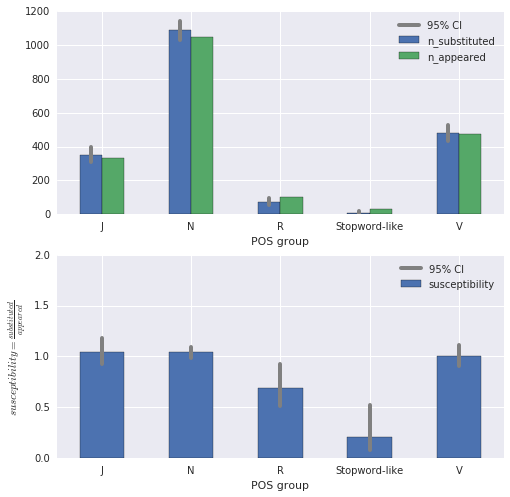

In [8]:
# Compute POS counts.
susties_pos = words[words.feature == 'aoa']\
    .groupby('rPOS')['target']\
    .aggregate({'susceptibility': susty_all,
                'n_substituted': target_all_counts,
                'n_appeared': appeared_all_counts})\
    .rename_axis('POS group')

# Plot.

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
# Raw substituted and appeared values.
susties_pos[['n_substituted', 'n_appeared']]\
    .plot(ax=axes[0], kind='bar', rot=0)
# With their CIs.
total_substituted = susties_pos.n_substituted.sum()
cis = multinomial_proportions_confint(susties_pos.n_substituted.round(),
                                      method='goodman')
for i in range(len(susties_pos)):
    axes[0].plot([i-.125, i-.125], cis[i] * total_substituted,
                 lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[0].legend()
# Substitutability values.
susties_pos['susceptibility']\
    .plot(ax=axes[1], kind='bar', legend=True, ylim=(0, 2), rot=0)
axes[1].set_ylabel(r'$susceptibility = \frac{substituted}{appeared}$')
# With their CIs.
for i in range(len(susties_pos)):
    axes[1].plot([i, i], (cis[i] * total_substituted 
                          / susties_pos.n_appeared.iloc[i]),
                 lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[1].legend(loc='best')
# Save if necessary.
if SAVE_FIGURES:
    fig.savefig(settings.FIGURE.format('all-susceptibilities-pos'),
                bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're in case (3) of the explanation below on confidence intervals (in section 3): it's really like a multinomial sampling, but not quite since not all POS tags are available to sample from in all the sentences. There's no way out of this, so we're going to use multinomial CIs. We can safely scale all the bars and CIs to their respective `n_appeared` values, since that is an independent given before the sampling.

**Are the appeared and substituted proportions statistically different?**

The only test we can easily do is a multinomial goodness-of-fit. This tells us if the `n_substituted` counts are significantly different from the reference `n_appeared` counts.

From there on we know a few things:
* Comparing a given POS's `n_substituted` count to its reference `n_appeared` count tells us if it's statistically different (< or >). We know this will be true individually for any POS that is out of its confidence region for the global goodness-of-fit test, since it's a weaker hypothesis (so the null rejection region will be wider, and the POS we're looking at is already in the rejection region for the global test). We don't know if it'll be true or not for POSes that are in their confidence region for the global test.
* Jointly comparing two POS's `n_substituted` counts to their reference `n_appeared` counts tells us if there is bias for one w.r.t. the other. This is also true for all pairs of POSes that are on alternate sides of their confidence region in the global test (for the same reasons as in the previous point). We don't know if it's true for the other POSes though.

In [9]:
# Test the n_substituted proportions are different from
# the n_appeared proportions
total_appeared = susties_pos.n_appeared.sum()
appeared_cis = multinomial_proportions_confint(
    susties_pos.n_appeared.round(), method='goodman')
differences = [(s < ci[0] * total_appeared) or (s > ci[1] * total_appeared)
               for s, ci in zip(susties_pos.n_substituted, appeared_cis)]
are_different = np.any(differences)
if are_different:
    print("Appeared and substituted proportions are different with p < .05")
    print("The following POS tags are out of their confidence region:",
          list(susties_pos.index[np.where(differences)[0]]))
else:
    print("Appeared and substituted proportions cannot be "
          "said different with p value better than .05")

Appeared and substituted proportions are different with p < .05
The following POS tags are out of their confidence region: ['R', 'Stopword-like']


## 3 On global feature values

Prepare plotting functions, for bin and quartile susceptibilities for each feature.

In [10]:
def print_significance(feature, h0s, heights):
    h0_total = h0s.sum()
    bin_count = len(h0s)
    print()
    print('-' * len(feature))
    print(feature)
    print('-' * len(feature))
    for n_stars, alpha in enumerate([.05, .01, .001]):
        h0_cis = multinomial_proportions_confint(h0s.round(),
                                                 method='goodman',
                                                 alpha=alpha)
        differences = ((heights < h0_cis[:, 0] * h0_total)
                       | (heights > h0_cis[:, 1] * h0_total))
        are_different = np.any(differences)
        stars = ' ' * (3 - n_stars) + '*' * (1 + n_stars)
        if are_different:
            bins_different = np.where(differences)[0]
            bins_different += np.ones_like(bins_different)
            print(stars + ' Target different H_0 with p < {}.'
                  ' Bins [1; {}] out of region: {}'
                  .format(alpha, bin_count, bins_different.tolist()))
        else:
            print('     Target NOT different from H_0 (p > {})'
                  .format(alpha))
            break

In [11]:
def plot_bin_susties(**kwargs):
    data = kwargs['data']
    feature = data.iloc[0].feature
    color = kwargs.get('color', 'blue')
    relative = kwargs.get('relative', False)
    quantiles = kwargs.get('quantiles', False)
    value = data.value_rel if relative else data.value
    
    # Compute binning.
    cut, cut_kws = ((pd.qcut, {}) if quantiles
                    else (pd.cut, {'right': False}))
    for bin_count in range(BIN_COUNT, 0, -1):
        try:
            value_bins, bins = cut(value, bin_count, labels=False,
                                   retbins=True, **cut_kws)
            break
        except ValueError:
            pass
    middles = (bins[:-1] + bins[1:]) / 2

    # Compute bin counts. Note here the bins are computed on the
    # distribution of observed substitutions, not the simulated aggregated
    # distributions of cluster-unit substitutions. But since it's mostly
    # deduplication that the aggregation process addresses, the bins
    # should be mostly the same. This could be corrected by computing
    # bins on the aggregate distribution (not hard), but it's really
    # not important now.
    heights = np.zeros(bin_count)
    h0s = np.zeros(bin_count)
    for i in range(bin_count):
        heights[i] = (data[data.target & (value_bins == i)]
                      .weight_feature.sum())
        h0s[i] = data[value_bins == i].weight_feature_appeared.sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = (r'\sigma_{\phi'
                + ('_r' if relative else '')
                + '}')
    plt.plot(middles, heights / h0s, 
             color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(middles, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(middles, np.ones_like(middles), '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xlim(middles[0], middles[-1])
    plt.ylim(0, 2)
    
    # Test for statistical significance
    print_significance(feature, h0s, heights)

In [12]:
def plot_grid(data, features, filename,
              plot_function, xlabel, ylabel, plot_kws={}):
    g = sb.FacetGrid(data=data[data['feature']
                               .map(lambda f: f in features)],
                     sharex=False, sharey=True,
                     col='feature', hue='feature',
                     col_order=features, hue_order=features,
                     col_wrap=3, aspect=1.5, size=3)
    g.map_dataframe(plot_function, **plot_kws)
    g.set_titles('{col_name}')
    g.set_xlabels(xlabel)
    g.set_ylabels(ylabel)
    for ax in g.axes.ravel():
        legend = ax.legend(frameon=True, loc='best')
        if not legend:
            # Skip if nothing was plotted on these axes.
            continue
        frame = legend.get_frame()
        frame.set_facecolor('#f2f2f2')
        frame.set_edgecolor('#000000')
        ax.set_title(Substitution._transformed_feature(ax.get_title())
                     .__doc__)
    if SAVE_FIGURES:
        g.fig.savefig(settings.FIGURE.format(filename),
                      bbox_inches='tight', dpi=300)

### 3.1 Bins of distribution of appeared global feature values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2]
     Target NOT different from H_0 (p > 0.01)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


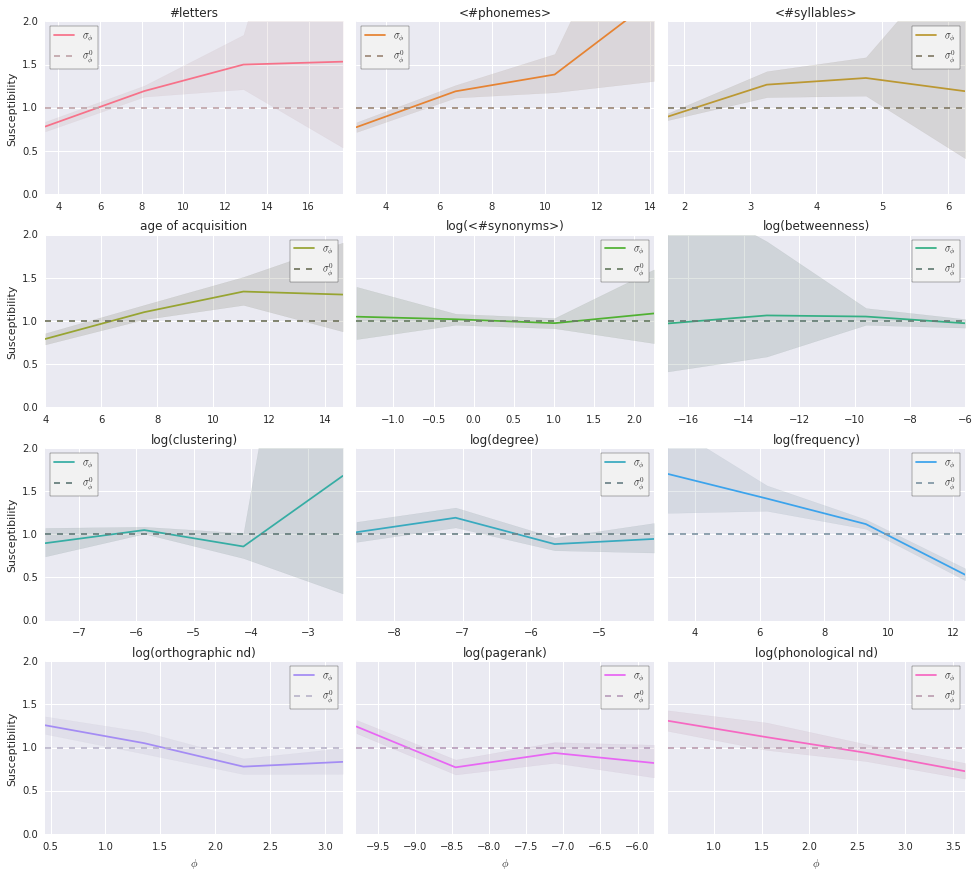

In [13]:
plot_grid(words, ordered_features,
          'all-susceptibilities-fixedbins_global',
          plot_bin_susties, r'$\phi$', 'Susceptibility')

**Note on how graphs and their confidence intervals are computed here**

There are three ways I can do a computation like above:

(1) For each word, we look at how many times it is substituted versus how many times it appears in a position where it could have been substituted. This is the *word*'s susceptibility, $\sigma(w)$. Then for each feature bin $b_i$ we take all the words such that $\phi(w) \in b_i$, average, and compute an asymptotic confidence interval based on how many words are in the bin. This fails for sentence-relative features, because a given word has different feature values depending on the sentence it appears in. So we discard this.

(2) Do the same but at the feature value level. So we define a *feature value* susceptibility, $\sigma_{\phi}(f)$, and compute a confidence interval based on how many different feature values we have in the bin. The idea behind (1) and (2) is to look at the bin middle-value like the relevant object we're measuring, and we have several measures for each bin middle-value, hence the confidence interval. In each bin $b_i$ we have:

$$\left< \sigma_{\phi}(f) \right>_{f \in b_i}$$

The problem with both (1) and (2) is that there's no proper $\mathcal{H}_0$ value, because the averages in the bins don't necessarily equal 1 under $\mathcal{H}_0$. Also, we can't check that there is consistency, showing that the sum of susceptibility values of the bins is 1. Hence case 3:

(3) Consider that we sample a multinomial process: each substitution is in fact the sampling of a feature value from one of the four bins. In that case, we can compute multinomial proportion CIs. This is also not completely satisfactory since in most cases not all feature values are available at the time of sampling, since most sentences don't range over all the feature's values, but it's what lets us compute proper null hypotheses: in each bin $b_i$ we have a value of $\sigma_{\phi}(b_i)$, and the sum of those should be the same under $\mathcal{H}_0$ as in the experiment (in practice in the graphs, we divide by the values under $\mathcal{H}_0$, and the reference is $\sigma_{\phi}^0(b_i) = 1$).

Here and below, we're always in case (3).


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]

-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


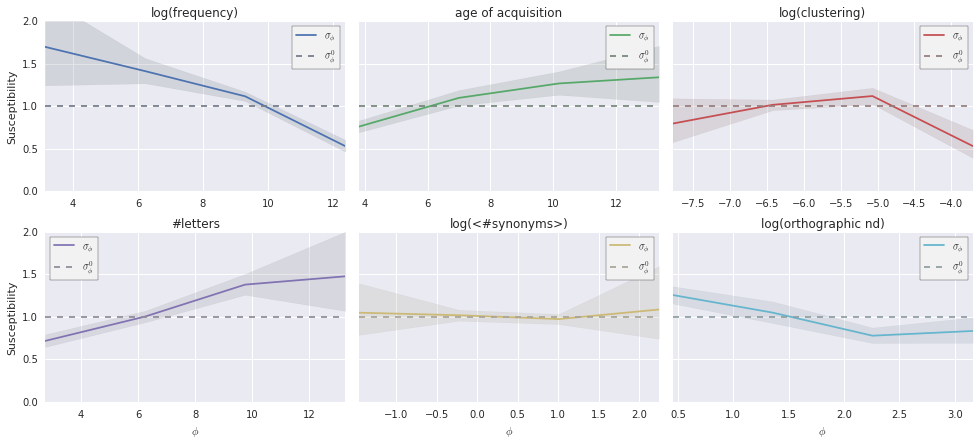

In [14]:
plot_grid(words[~(((words.feature == 'letters_count') 
                   & (words.value > 15))
                  | ((words.feature == 'aoa') 
                     & (words.value > 15))
                  | ((words.feature == 'clustering') 
                     & (words.value > -3)))],
          PAPER_FEATURES,
          'paper-susceptibilities-fixedbins_global',
          plot_bin_susties, r'$\phi$', 'Susceptibility')

### 3.2 Quantiles of distribution of appeared global feature values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 2] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 2] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 2] out of region: [1, 2]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


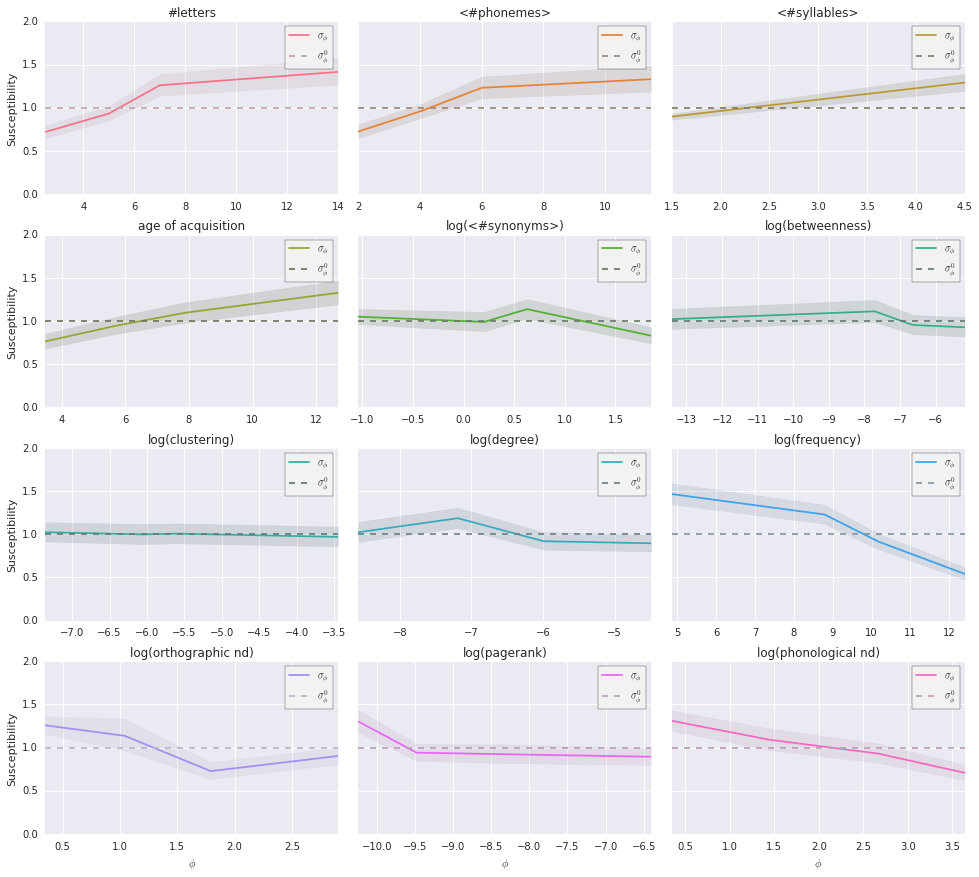

In [15]:
plot_grid(words, ordered_features,
          'all-susceptibilities-quantilebins_global', plot_bin_susties,
          r'$\phi$', 'Susceptibility',
          plot_kws={'quantiles': True})

**Note on confidence intervals**

Here we're again in case (2) of the above explanation on confidence intervals (in section 3.1), since we're just binning by quantiles instead of fixed-width bins.


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]

--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


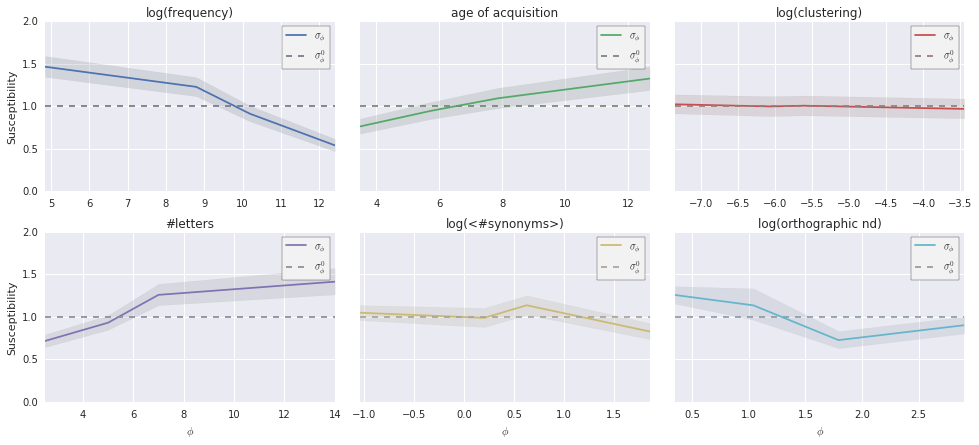

In [16]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-quantilebins_global', plot_bin_susties,
          r'$\phi$', 'Susceptibility',
          plot_kws={'quantiles': True})

## 4 On sentence-relative feature values

### 4.1 Bins of distribution of appeared sentence-relative values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [3]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
     Target NOT different from H_0 (p > 0.001)



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


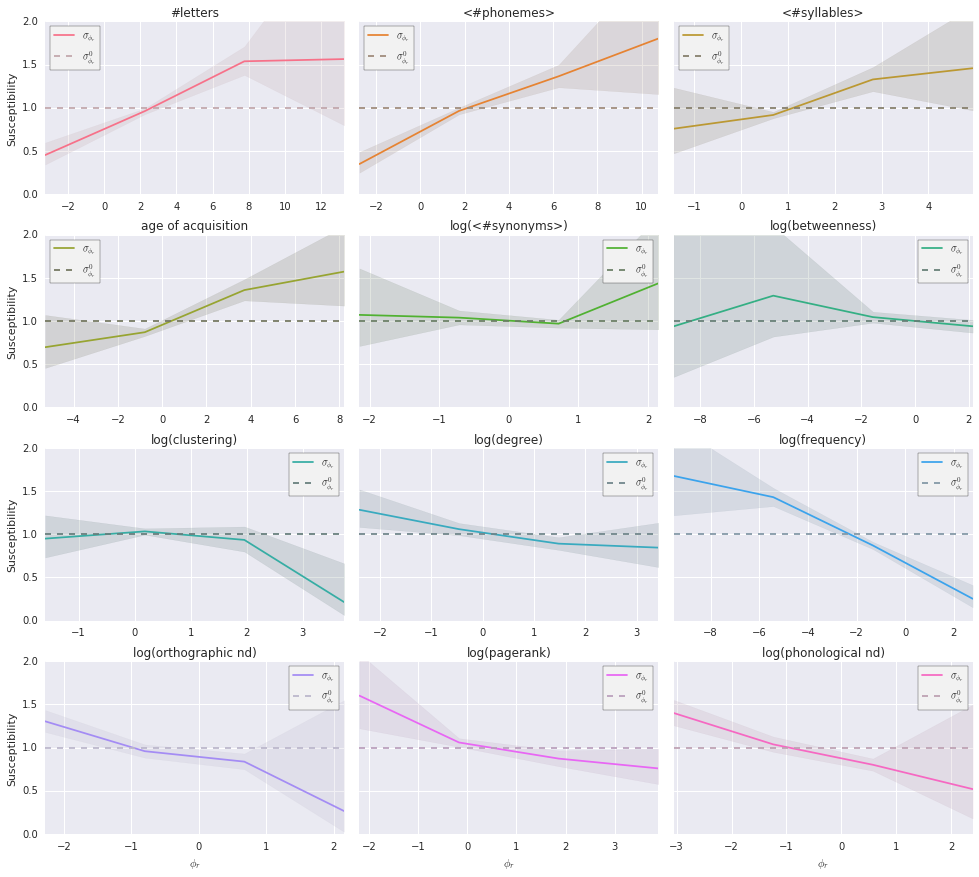

In [17]:
plot_grid(words, ordered_features,
          'all-susceptibilities-fixedbins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'relative': True})


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3]



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]

-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


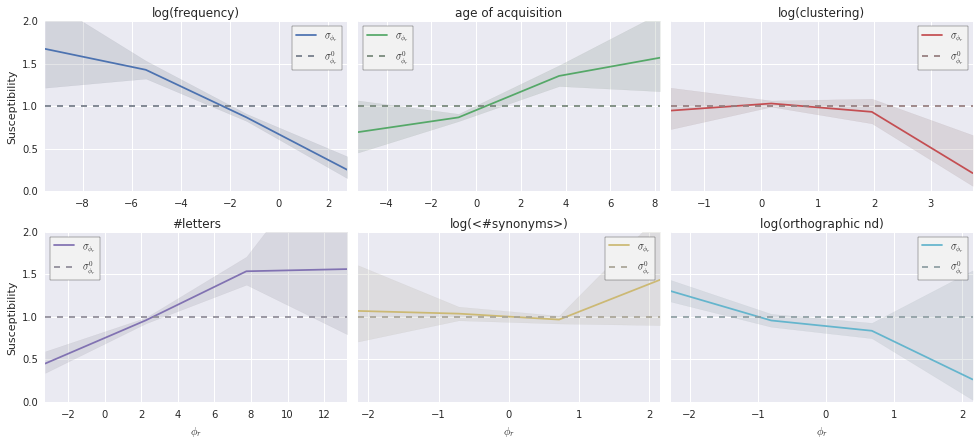

In [18]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-fixedbins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'relative': True})

### 4.2 Quantiles of distribution of appeared sentence-relative values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.01)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
     Target NOT different from H_0 (p > 0.001)



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


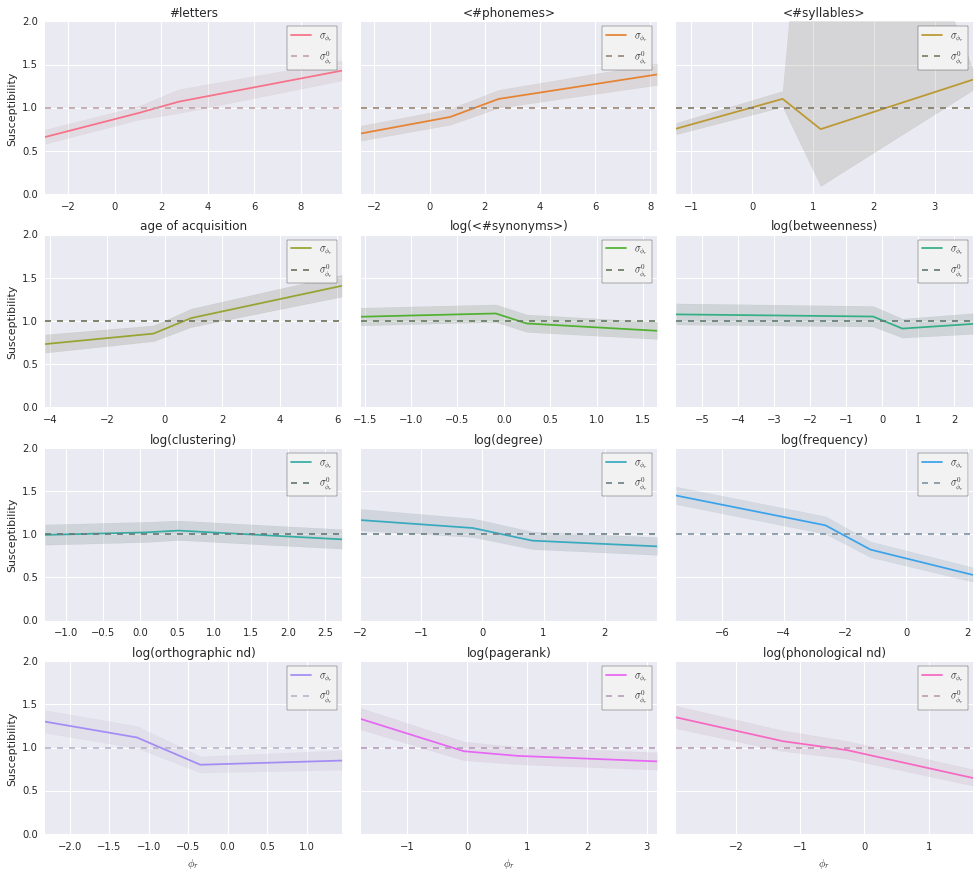

In [19]:
plot_grid(words, ordered_features,
          'all-susceptibilities-quantilebins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'quantiles': True, 'relative': True})


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.01)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


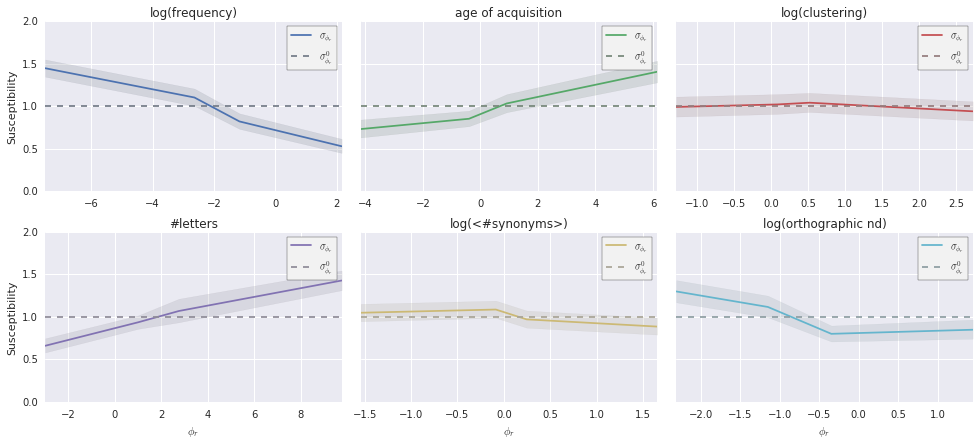

In [20]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-quantilebins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'quantiles': True, 'relative': True})

## 5 On quantiles and bins of the in-sentence distributions

### 5.1 In-sentence bins (of distribution of values in each sentence)

In [21]:
def plot_sentencebin_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    feature = data.iloc[0].feature
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    h0s = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = (data[data.target & (data.bin == i)]
                      .weight_feature.sum())
        h0s[i] = data[data.bin == i].weight_feature_appeared.sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = r'\sigma_{bin_{\phi}}'
    x = range(1, BIN_COUNT + 1)
    plt.plot(x, heights / h0s, color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(x, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(x, np.ones_like(x), '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xticks(x)
    plt.ylim(0, None)
    
    # Test for significance.
    print_significance(feature, h0s, heights)


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



-----------
betweenness
-----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.01)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


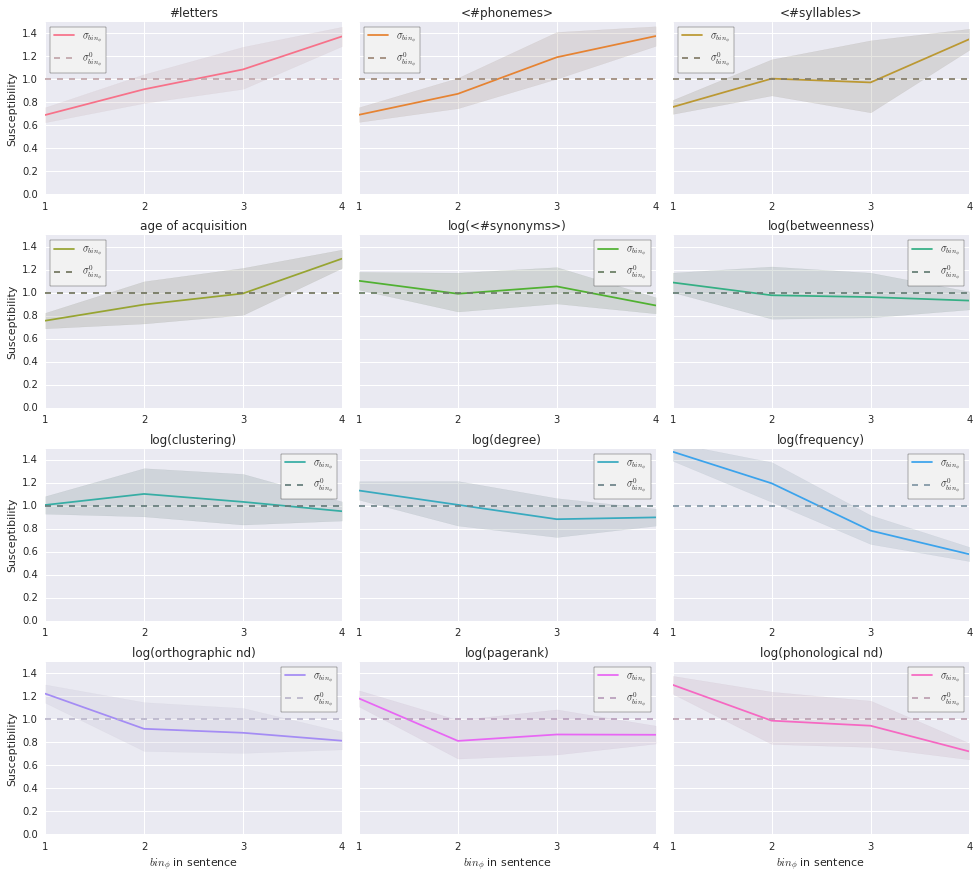

In [22]:
plot_grid(words, ordered_features,
          'all-susceptibilities-sentencebins',
          plot_sentencebin_susties, r'$bin_{\phi}$ in sentence',
          'Susceptibility')


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


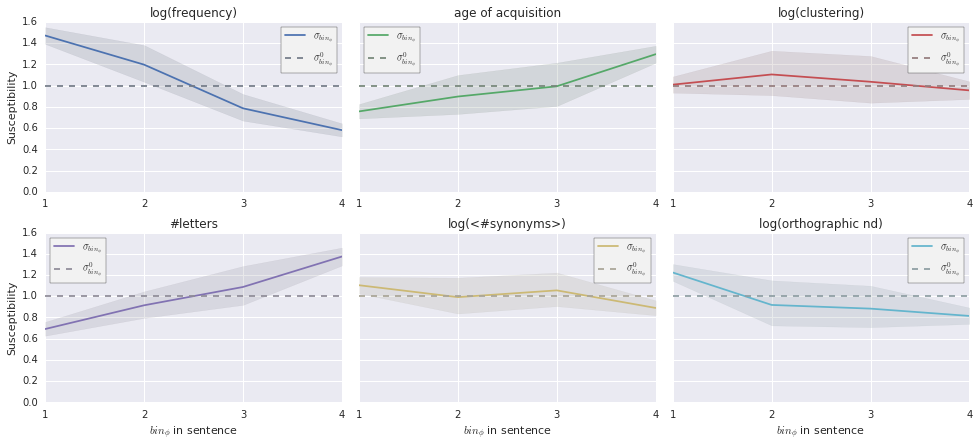

In [23]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-sentencebins',
          plot_sentencebin_susties, r'$bin_{\phi}$ in sentence',
          'Susceptibility')

### 5.2 In-sentence quantiles (of distribution of values in each sentence)

For each feature, count the sum of weights in each bin and plot that.

In [24]:
def bound(limits, values):
    left, right = limits
    assert left < right
    return np.maximum(left, np.minimum(right, values))

In [25]:
def plot_sentencequantile_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    feature = data.iloc[0].feature
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    h0s = np.zeros(BIN_COUNT)
    step = 1 / BIN_COUNT
    for i in range(BIN_COUNT):
        limits = [i * step, (i + 1) * step]
        contributions = ((bound(limits, data.stop_quantile)
                          - bound(limits, data.start_quantile))
                         / (data.stop_quantile - data.start_quantile))
        heights[i] = \
            (contributions * data.weight_feature)[data.target].sum()
        h0s[i] = (contributions * data.weight_feature_appeared).sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total)# / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = r'\sigma_{q_{\phi}}'
    x = range(1, BIN_COUNT + 1)
    plt.plot(x, heights,# / h0s,
             color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(x, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(x, h0s, '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xticks(x)
    plt.ylim(0, None)
    
    # Test for significance.
    print_significance(feature, h0s, heights)


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.001)



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


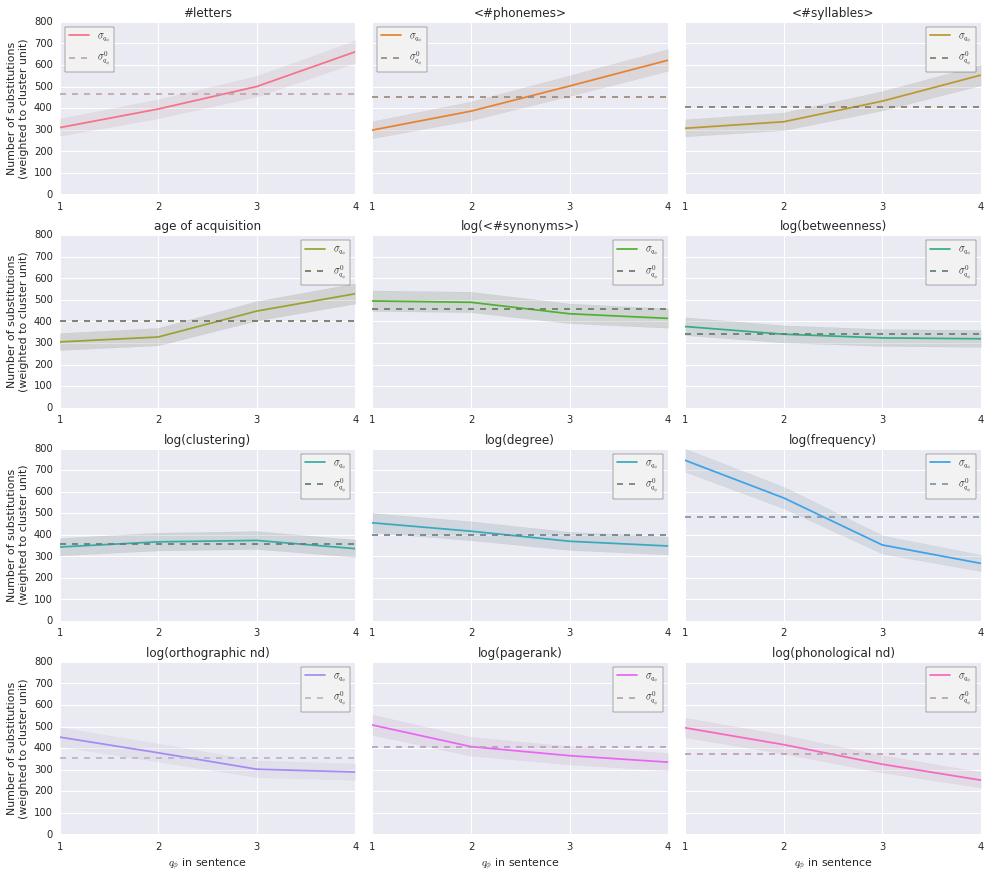

In [26]:
plot_grid(words, ordered_features,
          'all-susceptibilities-sentencequantiles',
          plot_sentencequantile_susties, r'$q_{\phi}$ in sentence',
          'Number of substitutions\n(weighted to cluster unit)')


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


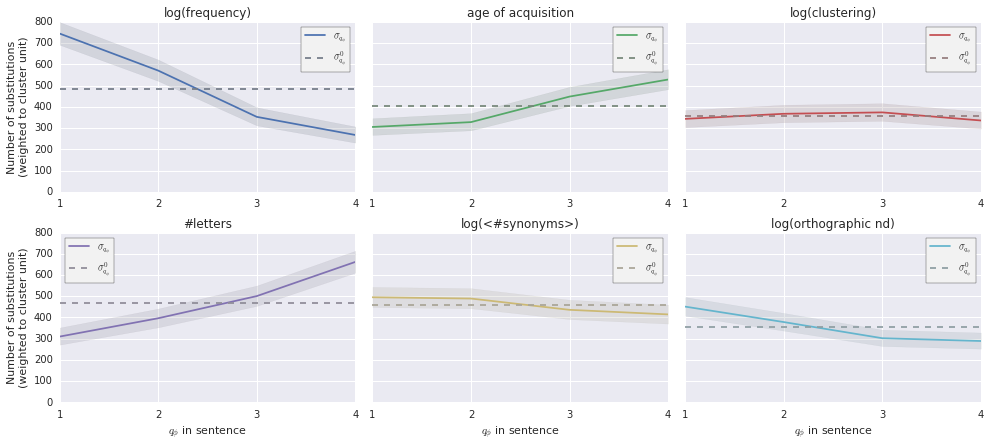

In [27]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-sentencequantiles',
          plot_sentencequantile_susties, r'$q_{\phi}$ in sentence',
          'Number of substitutions\n(weighted to cluster unit)')

## 6 Regression on significant features

### 6.1 Multinomial logistic regression

We try to predict which words are substituted, based on their global values, sentence-relative values, bins and quantiles of those, or in-sentence bin values.

Prediction is not good, mainly because the constraint of one-substitution-per-sentence can't be factored in the model simply. So precision is generally very low, around .20-.25, and when accuracy goes up recall plummets.

So it might show some interaction effects, but given that the fit is very bad I wouldn't trust it.

In-sentence quantiles (from section 5.2) were not done, as they're impossible to reduce to one value (our measure of those quantiles is in fact a subrange of [0, 1] for each word, corresponding to the subrange of the sentence distribution that that word's feature value represented).

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import binom_test

In [29]:
def regress_binning(data, features, value_funcs):
    # Compute bins
    data = data.copy()
    regress_features = [('{}'.format(value_name), feature)
                        for value_name in value_funcs.keys()
                        for feature in features]
    for i, (value_name, value_func) in enumerate(value_funcs.items()):
        data[value_name] = value_func(data)
    
    # Massage the dataframe to have feature bin as columns.
    data_wide = pd.pivot_table(
        data,
        values=list(value_funcs.keys()),
        index=['destination_id', 'occurrence', 'source_id', 'position',
               'word_position'],
        columns=['feature']
    )[regress_features]

    # Add the target value.
    # Question/FIXME: should we use weight_appeared for regression?
    data_wide['target'] = pd.pivot_table(
        data,
        values=['target'],
        index=['destination_id', 'occurrence', 'source_id', 'position',
               'word_position'],
        columns=['feature']
    )[('target', 'aoa')]
    data_wide = data_wide.dropna()

    # Compute polynomial features.
    poly = PolynomialFeatures(degree=2, interaction_only=True)
    pdata = poly.fit_transform(data_wide[regress_features])
    pregress_features = [' * '.join(['_'.join(regress_features[j])
                                   for j, p in enumerate(powers)
                                   if p > 0]) or 'intercept'
                         for powers in poly.powers_]

    # Divide into two sets.
    print('Regressing with {} word measures (divided into'
          ' training and prediction sets)'
          .format(len(data_wide)))
    pdata_train = pdata[:len(data_wide) // 2]
    target_train = data_wide.iloc[:len(data_wide) // 2].target
    pdata_predict = pdata[len(data_wide) // 2:]
    target_predict = data_wide.iloc[len(data_wide) // 2:].target
    assert len(pdata_train) + len(pdata_predict) == len(data_wide)
    assert len(target_train) + len(target_predict) == len(data_wide)
    
    # Regress
    regressor = LogisticRegression(penalty='l2', class_weight='balanced',
                                   fit_intercept=False)
    regressor.fit(pdata_train, target_train)
    
    # And predict
    prediction = regressor.predict(pdata_predict)
    standard = target_predict.values
    success = prediction == standard
    
    tp = prediction & standard
    tn = (~prediction) & (~standard)
    fp = prediction & (~standard)
    fn = (~prediction) & standard
    
    print()
    print('{:.2f}% of words well predicted (non-random at p = {:.1})'
          .format(100 * success.mean(),
                  binom_test(success.sum(), len(success))))
    print('Precision = {:.2f}'.format(standard[prediction].mean()))
    print('Recall = {:.2f}'.format(prediction[standard].mean()))
    print()
    print('Coefficients:')
    print(pd.Series(index=pregress_features, data=regressor.coef_[0]))

**Global feature value**

In [30]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'global': lambda d: d.value})

Regressing with 53291 word measures (divided into training and prediction sets)



51.99% of words well predicted (non-random at p = 8e-11)
Precision = 0.30
Recall = 0.48

Coefficients:
intercept                                             2.245192
global_frequency                                     -0.042324
global_aoa                                           -0.555475
global_letters_count                                  0.192636
global_orthographic_density                          -0.025918
global_frequency * global_aoa                         0.037798
global_frequency * global_letters_count              -0.047815
global_frequency * global_orthographic_density       -0.010560
global_aoa * global_letters_count                     0.028954
global_aoa * global_orthographic_density              0.035239
global_letters_count * global_orthographic_density   -0.045490
dtype: float64


**Sentence-relative feature value**

In [31]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'sentence-rel': lambda d: d.value_rel})

Regressing with 53291 word measures (divided into training and prediction sets)



62.09% of words well predicted (non-random at p = 5e-324)
Precision = 0.38
Recall = 0.50

Coefficients:
intercept                                                        -0.218267
sentence-rel_frequency                                           -0.118853
sentence-rel_aoa                                                  0.069635
sentence-rel_letters_count                                       -0.164013
sentence-rel_orthographic_density                                 0.076440
sentence-rel_frequency * sentence-rel_aoa                         0.019286
sentence-rel_frequency * sentence-rel_letters_count              -0.029504
sentence-rel_frequency * sentence-rel_orthographic_density        0.016933
sentence-rel_aoa * sentence-rel_letters_count                     0.018007
sentence-rel_aoa * sentence-rel_orthographic_density              0.040412
sentence-rel_letters_count * sentence-rel_orthographic_density   -0.045852
dtype: float64


**Global + sentence-relative feature values**

In [32]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'global': lambda d: d.value,
                 'sentence-rel': lambda d: d.value_rel})

Regressing with 53291 word measures (divided into training and prediction sets)



60.74% of words well predicted (non-random at p = 2e-271)
Precision = 0.37
Recall = 0.51

Coefficients:
intercept                                                         -0.871983
sentence-rel_frequency                                            -0.750452
sentence-rel_aoa                                                  -0.114453
sentence-rel_letters_count                                         0.057315
sentence-rel_orthographic_density                                  0.516173
global_frequency                                                   0.462110
global_aoa                                                        -0.927519
global_letters_count                                               0.284674
global_orthographic_density                                       -0.192392
sentence-rel_frequency * sentence-rel_aoa                         -0.072775
sentence-rel_frequency * sentence-rel_letters_count               -0.096768
sentence-rel_frequency * sentence-rel_orthographic_density 

**(3.1) Bins of distribution of appeared global feature values**

In [33]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'bins-global':
                     lambda d: pd.cut(d.value, BIN_COUNT,
                                      labels=False, right=False)})

Regressing with 53291 word measures (divided into training and prediction sets)



49.43% of words well predicted (non-random at p = 0.07)
Precision = 0.33
Recall = 0.72

Coefficients:
intercept                                                      -1.238607
bins-global_frequency                                          -0.651837
bins-global_aoa                                                 3.602611
bins-global_letters_count                                      -1.378830
bins-global_orthographic_density                               -1.935836
bins-global_frequency * bins-global_aoa                        -0.444236
bins-global_frequency * bins-global_letters_count               0.893095
bins-global_frequency * bins-global_orthographic_density       -0.294710
bins-global_aoa * bins-global_letters_count                    -0.927545
bins-global_aoa * bins-global_orthographic_density             -0.723210
bins-global_letters_count * bins-global_orthographic_density    2.012721
dtype: float64


**(3.2) Quantiles of distribution of appeared global feature values**

In [34]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'quantiles-global':
                     lambda d: pd.qcut(d.value, BIN_COUNT, labels=False)})

Regressing with 53291 word measures (divided into training and prediction sets)



49.80% of words well predicted (non-random at p = 0.5)
Precision = 0.31
Recall = 0.59

Coefficients:
intercept                                                                 0.749019
quantiles-global_frequency                                                1.245969
quantiles-global_aoa                                                      0.686972
quantiles-global_letters_count                                           -1.475741
quantiles-global_orthographic_density                                    -3.364384
quantiles-global_frequency * quantiles-global_aoa                        -0.939942
quantiles-global_frequency * quantiles-global_letters_count               0.002864
quantiles-global_frequency * quantiles-global_orthographic_density        1.154111
quantiles-global_aoa * quantiles-global_letters_count                     0.746094
quantiles-global_aoa * quantiles-global_orthographic_density              0.392326
quantiles-global_letters_count * quantiles-global_orthographic_densi

**(4.1) Bins of distribution of appeared sentence-relative values**

In [35]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'bins-sentence-rel':
                     lambda d: pd.cut(d.value_rel, BIN_COUNT,
                                      labels=False, right=False)})

Regressing with 53291 word measures (divided into training and prediction sets)

68.79% of words well predicted (non-random at p = 5e-324)
Precision = 0.42
Recall = 0.21

Coefficients:
intercept                                                                   0.270556
bins-sentence-rel_frequency                                                -0.356910
bins-sentence-rel_aoa                                                       0.003569
bins-sentence-rel_letters_count                                            -0.050123
bins-sentence-rel_orthographic_density                                      0.270556
bins-sentence-rel_frequency * bins-sentence-rel_aoa                        -0.099867
bins-sentence-rel_frequency * bins-sentence-rel_letters_count               0.032346
bins-sentence-rel_frequency * bins-sentence-rel_orthographic_density       -0.356910
bins-sentence-rel_aoa * bins-sentence-rel_letters_count                     0.170518
bins-sentence-rel_aoa * bins-sentence-rel_orthogra

**(4.2) Quantiles of distribution of appeared sentence-relative values**

In [36]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'quantiles-sentence-rel':
                     lambda d: pd.qcut(d.value_rel, BIN_COUNT,
                                       labels=False)})

Regressing with 53291 word measures (divided into training and prediction sets)

49.19% of words well predicted (non-random at p = 0.009)
Precision = 0.30
Recall = 0.57

Coefficients:
intercept                                                                             0.223589
quantiles-sentence-rel_frequency                                                      0.280591
quantiles-sentence-rel_aoa                                                           -0.351929
quantiles-sentence-rel_letters_count                                                 -0.072557
quantiles-sentence-rel_orthographic_density                                          -0.124614
quantiles-sentence-rel_frequency * quantiles-sentence-rel_aoa                         0.038277
quantiles-sentence-rel_frequency * quantiles-sentence-rel_letters_count              -0.299301
quantiles-sentence-rel_frequency * quantiles-sentence-rel_orthographic_density       -0.049138
quantiles-sentence-rel_aoa * quantiles-sentence-rel_lett

**(5.1) In-sentence bins (of distribution of values in each sentence)**

In [37]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'in-sentence-bins': lambda d: d.bin})

Regressing with 53291 word measures (divided into training and prediction sets)

65.84% of words well predicted (non-random at p = 5e-324)
Precision = 0.42
Recall = 0.48

Coefficients:
intercept                                                                -0.582791
in-sentence-bins_frequency                                                0.013771
in-sentence-bins_aoa                                                      0.158647
in-sentence-bins_letters_count                                            0.305035
in-sentence-bins_orthographic_density                                     0.291063
in-sentence-bins_frequency * in-sentence-bins_aoa                        -0.082609
in-sentence-bins_frequency * in-sentence-bins_letters_count              -0.088243
in-sentence-bins_frequency * in-sentence-bins_orthographic_density       -0.057646
in-sentence-bins_aoa * in-sentence-bins_letters_count                     0.004707
in-sentence-bins_aoa * in-sentence-bins_orthographic_density        

### 6.2 PCA

We get coefficient values out of the PCA, but I can't figure what to make of them... They reflect the correlations of the features, alright, but beyond that? Some interactions, but there's no clear interpretation of the coefficients and variances explained into interaction strengths.

In [38]:
from sklearn.decomposition import PCA

In [39]:
def pca_values(data, features, value_func):
    data = data.copy()
    data['pca_value'] = value_func(data)
    
    # Prepare dataframe, averaging over shared durl.
    data_wide = pd.pivot_table(
        data[data.target],
        values='pca_value',
        index=['cluster_id', 'destination_id', 'occurrence',
               'position'],
        columns=['feature']
    )[features]
    # ... then over shared clusters, and dropping NaNs.
    data_wide = data_wide\
        .groupby(level='cluster_id')\
        .agg(np.mean)\
        .dropna(how='any')
    print('Computing PCA on {} aggregated word measures'
          .format(len(data_wide)))
    print()
    
    # Compute PCA.
    pca = PCA(n_components='mle')
    pca.fit(data_wide)
    print('Variance explained by first {} components (mle-estimated): {}'
          .format(pca.n_components_, pca.explained_variance_ratio_))
    print()
    print('Components:')
    print(pd.DataFrame(index=data_wide.columns,
                       data=pca.components_.T,
                       columns=['Comp. {}'.format(i)
                                for i in range(pca.n_components_)]))

**PCA of feature value of substituted words**

In [40]:
pca_values(words, ['frequency', 'aoa', 'letters_count'],
           lambda d: d.value)

Computing PCA on 1556 aggregated word measures

Variance explained by first 2 components (mle-estimated): [ 0.71080352  0.16438311]

Components:
                Comp. 0   Comp. 1
feature                          
frequency      0.340410 -0.660791
aoa           -0.732087  0.260187
letters_count -0.590059 -0.704030


**PCA of sentence-relative value of substituted words**

In [41]:
pca_values(words, ['frequency', 'aoa', 'letters_count'],
           lambda d: d.value_rel)

Computing PCA on 1556 aggregated word measures

Variance explained by first 2 components (mle-estimated): [ 0.6361041   0.19860368]

Components:
                Comp. 0   Comp. 1
feature                          
frequency      0.454377 -0.717985
aoa           -0.636291  0.152675
letters_count -0.623437 -0.679109
